# Assignment 1 - Steady-State Conduction

#Solve each of the following problems and explain your results. For each problem, determine an appropriate number of control volumes through a grid independence study. Determine the number of iterations required for convergence and comment on the result.

## Problem 1 - Linear Heat Conduction

Solve for the one-dimensional temperature distribution in a square bar of mild steel as given below. The properties of mild steel are:

 - $k$ = 60 [W/m$\cdot$K]
 - $\rho$ = 7800 [kg/m$^3$]
 - $c_p$ = 430 [J/kg$\cdot$K]
 
Assume the convection coefficient is zero on the exposed surfaces, and fixed end temperatures of $T_1$ =100 [$^\circ$C] and $T_2$ = 0 [$^\circ$C].

![SquareBar](Figures/1-SquareBar.png)

In [387]:
## CLASSES DEFINED TO BE USED IN ALL THE PROBLEMS of this assignment

##Grid definition

import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [388]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [389]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2
    

In [390]:
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

In [391]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

In [392]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [393]:
#Problem 1 for a number of control volumes of 15

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373.15, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273.15, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 24.035999999999994; Avg. Resid. = 3.0089999999999986
Iteration = 1; Max. Resid. = 3.3306690738754696e-15; Avg. Resid. = 1.304512053934559e-15


## Results #1 obtained:

For this problem, the solution converged within one iteration, this is since the method used to approach the solution was linearized and all the coefficients that bellongs to the Jacobian matrix to solve the system of equations is linear. The following plot shows how does the temperature decays along the x-axis, since it is a one-dimensional analysis. 

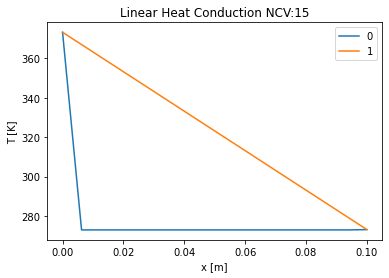

In [394]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("Linear Heat Conduction NCV:15")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_solns_1 = T_solns.copy()
grid1_xP = grid.xP

#print(grid.xP)
#print(T_solns_1)

In [395]:
#Problem 1 for a number of control volumes of 30

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373.15, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273.15, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 90.13499999999998; Avg. Resid. = 3.0089999999999986
Iteration = 1; Max. Resid. = 3.197442310920451e-14; Avg. Resid. = 1.295260195396016e-14


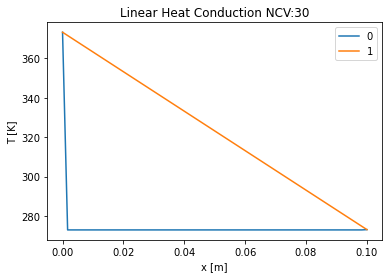

In [396]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("Linear Heat Conduction NCV:30")    
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_solns_2 = T_solns.copy()
grid2_xP=grid.xP

In [397]:
#Problem 1 for a number of control volumes of 60

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 60
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373.15, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273.15, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 180.26999999999995; Avg. Resid. = 3.0089999999999986
Iteration = 1; Max. Resid. = 9.614531393253856e-14; Avg. Resid. = 2.903973358077868e-14


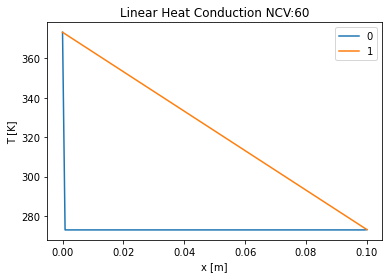

In [398]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    
    plt.plot(grid.xP, T, label=str(i))
    i += 1
plt.title("Linear Heat Conduction NCV:60")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_solns_3 = T_solns.copy()
grid3_xP=grid.xP

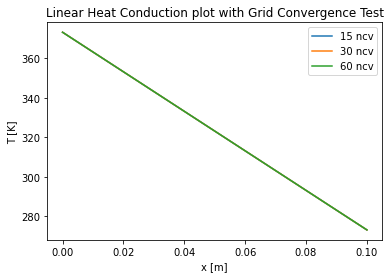

In [399]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax = plt.subplots()

ax.plot(grid1_xP, T_solns_1[-1], label="15 ncv")
ax.plot(grid2_xP, T_solns_2[-1], label="30 ncv")
ax.plot(grid3_xP, T_solns_3[-1], label="60 ncv")

ax.set_title("Linear Heat Conduction plot with Grid Convergence Test")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.legend()
plt.show()

### Analysis on the results for problem 1

Grid convergenge: The previous plot shows all the curves that the result of each calculation for the linear heat conduction through the bar. It possible to notice that all the curves are the same, since the result is similar for all the different number of control volume used. This provides information about the accuracy of the method used for this application as it provides a result that can satisty  the convergence and residuals requirements. 

Since all the grids provide the same result, the most optimal grid to use in this case will be the number of control volumes of 15, since is the coarsest, the number of calculations will be reduced as the grid is less without compromising the accuracy in the result. 

It is also noticeable that the residual changes one order og magnitud between the grid of 15 NCV and the ones with 30 and 60 NCV respectivelly. This does not affect the accuracy of the method in this case since it provides a residual that satisfy the requirements.

For all the results obtained, is noticeable that all the solutions converge in only one iteration, this is due to the linearization method used to prepare the Jacobian matrix used to solve the system of equations to solve the temperature distribution on the bar.

On another hand, on the bar is possible to see how does the temperature changes just by the effect of conduction over the bar, since the steel have a high conductivity the temperature drops drastically over the bar from one boundary to the other.

## Problem 2 - External Convection

Consider the same geometry and properties as in problem 1, except use $h$ = 12 [W/m$^2\cdot$K] for the exposed surfaces of the bar, and end temperatures of $T_1$ = $T_2$ = 100 [$^\circ$C].  Assume the surrounding air to be at $T_{\infty}$ = 25 [$^\circ$C]. Obtain the solution for this problem and compare your solution to the analytical solution.


### Solution External Convection
Using previous classes definitions, we will just add the Surface Convection Model and redefine the
new data to this external convection problem.
In this case beside using Dirichlet for the Boundary Conditions definition, it was used a convective heat source defined in the class of the SurfaceConvectionModel, where the source will be the effect of the convection in the bar since it is a one dimensional problem.

In [400]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        
        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [401]:
#Problem 2 for a number of control values of 10

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 273.15+25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    print(T_solns[-1])

Iteration = 0; Max. Resid. = 30.06036; Avg. Resid. = 6.0603599999999975
[373.         370.35687626 366.22593879 363.18421635 361.18304137
 360.19039505 360.19039505 361.18304137 363.18421635 366.22593879
 370.35687626 373.        ]
Iteration = 1; Max. Resid. = 1.5015766408055242e-14; Avg. Resid. = 9.43689570931383e-15


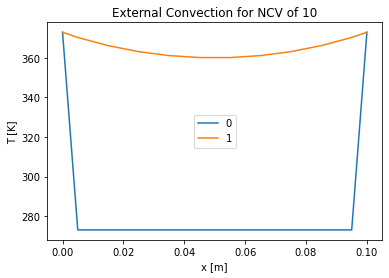

In [402]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("External Convection for NCV of 10")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_solns_1 = T_solns.copy()
grid1_xP=grid.xP

In [403]:
#Problem 2 for a number of control volumes of 20

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 273.15+25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    print(T_solns[-1])

Iteration = 0; Max. Resid. = 60.03018; Avg. Resid. = 6.030179999999997
[373.         371.67594652 369.32194334 367.25262794 365.45972305
 363.93605705 362.67553528 361.67311565 360.92478848 360.42756047
 360.1794427  360.1794427  360.42756047 360.92478848 361.67311565
 362.67553528 363.93605705 365.45972305 367.25262794 369.32194334
 371.67594652 373.        ]
Iteration = 1; Max. Resid. = 1.4238610290817633e-14; Avg. Resid. = 7.632783294297951e-15


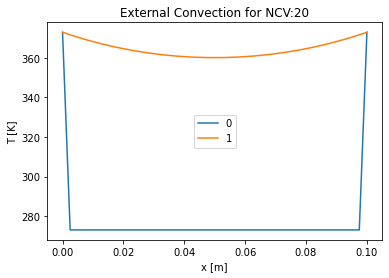

In [404]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("External Convection for NCV:20")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_solns_2 = T_solns.copy()
grid2_xP=grid.xP

In [405]:
#Problem 2 for a number of control volumes of 40

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 273.15+25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    print(T_solns[-1])

Iteration = 0; Max. Resid. = 120.01509; Avg. Resid. = 6.015089999999997
[373.         372.3376609  371.08717036 369.90961699 368.80382323
 367.7686833  366.80316206 365.90629397 365.07718218 364.31499757
 363.61897796 362.98842732 362.42271512 361.92127563 361.48360741
 361.1092728  360.79789747 360.54917003 360.36284176 360.23872634
 360.17669964 360.17669964 360.23872634 360.36284176 360.54917003
 360.79789747 361.1092728  361.48360741 361.92127563 362.42271512
 362.98842732 363.61897796 364.31499757 365.07718218 365.90629397
 366.80316206 367.7686833  368.80382323 369.90961699 371.08717036
 372.3376609  373.        ]
Iteration = 1; Max. Resid. = 6.317862899507531e-14; Avg. Resid. = 2.3995562481449184e-14


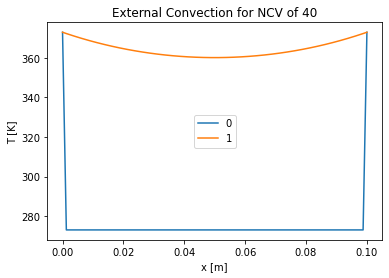

In [406]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("External Convection for NCV of 40")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_solns_3 = T_solns.copy()
grid3_xP=grid.xP

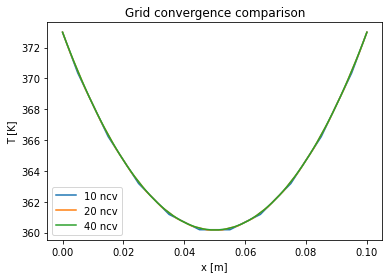

In [407]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2, ax = plt.subplots()

plt.title("Grid convergence comparison")
ax.plot(grid1_xP, T_solns_1[-1], label="10 ncv")
ax.plot(grid2_xP, T_solns_2[-1], label="20 ncv")
ax.plot(grid3_xP, T_solns_3[-1], label="40 ncv")


ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.legend()
plt.show()

### Grid convergence analysis

Based on the previous plot, is possible to notice that for all the grid used the solution converges to the same result, with a slight difference with the coarse mesh that uses a number of control volumes of 10. In this case, the grid selected as an optimal grid is the one that uses 20 control volumes, based on the results shown in the plot it provides an accurate result without using a finer mesh that could use more computational time and memory providing the same result. 

### Analytical Solution 

For this problem, to obtain an analytical solution, an approximation to an external convection over a uniform geometry fin was used. Based on the equations used to calculate the temperature distribution over the fin, the following calculations were coded in order to obtain a comparable results with the numerical solution obtained before.

[373.15       371.85974017 369.49915151 367.4240546  365.62614629
 364.09823255 362.83419967 361.82898985 361.07858091 360.57997021
 360.33116264 360.33116264 360.57997021 361.07858091 361.82898985
 362.83419967 364.09823255 365.62614629 367.4240546  369.49915151
 371.85974017 373.15      ]


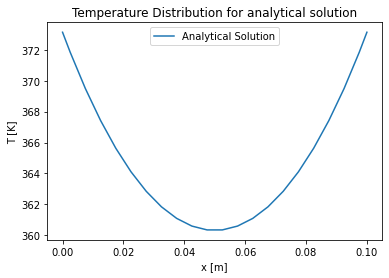

In [408]:
##ANALYTICAL SOLUTION

import math 

#Ambient Temperature

To = 273.15+25

#Temperature at the boundaries

Tl=373.15-To
Tb=373.15-To

#grid definition

grid_an = grid2_xP

#Parameters
P = (2*lz) + (2*ly)
Ac = lz*ly

#Calculation of m

m = math.sqrt((ho*P)/(k*Ac))

#Calculation of theta over thetab

c=(((Tl/Tb)*np.sinh(m*grid_an))+(np.sinh(m*(lx-grid_an))))/(np.sinh(m*lx))
#print(c)

T_an=(c*Tb)+To
print(T_an)

%matplotlib inline
import matplotlib.pyplot as plt

fig3, ax = plt.subplots()

plt.title("Temperature Distribution for analytical solution")
ax.plot(grid_an, T_an, label="Analytical Solution")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.legend()
plt.show()




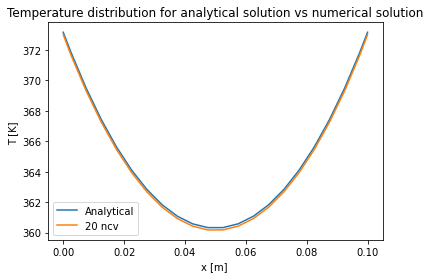

In [409]:
fig4, ax = plt.subplots()

ax.plot(grid_an, T_an, label="Analytical")
ax.plot(grid2_xP, T_solns_2[-1], label="20 ncv")


plt.title("Temperature distribution for analytical solution vs numerical solution")
ax.set_xlabel("x [m] ")
ax.set_ylabel("T [K] ")
ax.legend()
plt.show()

### Analysis of the results

The results obtained from the analytical and numerical solution, shows the effects of the convection on the bar and how the temperature decrease along the x-axis in the bar, generating the lower temperature in the middle of the bar since both extremes have boundary conditions fixed.

This result is expected to happen as the analytical solution shows, since the external conduction is removing heat from the bar. Compared with the problem 1 where only conduction was being applied, this problem 2 shows how the effect of external convection can reduce the temperature distribution gradually along the bar.

The aproximation of the numerical solution to the analytical solution shows to be accurate, which determines the accuracy of the model as expected. 

Since this analysis is done in one dimension, the addition of the convective effect as a source was able to provide an accurate result. 

Also in this case the linearization of the terms provided a linear system of equations will allows the solutions to be done with only one iteration achieving the expected residual. 

## Problem 3 - Internal Heat Generation

A plane wall $L$ = 0.1 [m] thick with a thermal conductivity of $k$ = 26 [W/m$\cdot$K] is exposed to an environment at an ambient temperature of 50 [$^\circ$C] on one side and an environment of 40 [$^\circ$C] on the other side. The convection coefficient at the exposed surfaces is estimated to be $h$ = 280 [W/m$^2\cdot$K]. If heat is generated uniformly within the wall at a rate 50,000 [W/m$^3$], determine the surface temperatures of the walls, and the location and value of the maximum temperature inside the wall. Compare your result to the analytical result, which can be obtained from a heat transfer textbook.

In [410]:
##Using the same previous classes defined, in this case considering the set up of the boundary conditions
# and the conditions of the source, the following classes are developed:

class RobinBc:
    """Class defining a Neumann boundary condition"""
   
    def __init__(self, phi, grid, h, k, To, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            h........... convection coefficient
            k........... thermal conductivity
            Tamb........ ambient temperature
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._h = h
        self._k = k
        self._To = To
        self._loc = loc
       
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._To))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            return (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._To))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")
   
    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return (1/(1+((self._h/self._k)*self._grid.dx_WP[0])))
        elif self._loc is BoundaryLocation.EAST:
            return (1/(1+((self._h/self._k)*self._grid.dx_PE[-1])))
     
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._To))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._To))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")
            

In [411]:
class InternalConvection:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, qo):
        
        """Constructor"""
        self._grid = grid
        self._qo = qo
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source =  qo*self._grid.vol
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(-source)
        
        return coeffs
    

In [412]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ho = 280

#Ambient temperatures
T1=323
T2=313

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 323

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = RobinBc(T, grid, ho, k, T1, BoundaryLocation.WEST) #self, phi, grid, h, k, Tamb, loc
east_bc = RobinBc(T, grid, ho, k, T2, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
qo=50000
Internal = InternalConvection(grid, qo)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = Internal.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    print(T_solns[-1])

Iteration = 0; Max. Resid. = 0.05392335766423508; Avg. Resid. = 0.01664233576642277
[328.67857143 328.98434066 329.40357143 329.63049451 329.66510989
 329.50741758 329.15741758 328.61510989 327.88049451 326.95357143
 325.83434066 325.17857143]
Iteration = 1; Max. Resid. = 4.557118571391072e-15; Avg. Resid. = 2.5625335187129395e-15


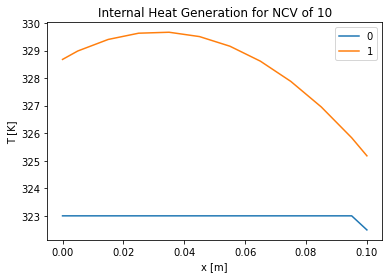

In [413]:
##POST PROCESSING

%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("Internal Heat Generation for NCV of 10")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_solns_1 = T_solns.copy()
grid1_xP=grid.xP

In [414]:
##Problem 3 with a number of control volumes of 20

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 20
ncv2 = ncv
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ho = 280

#Ambient temperatures
T1=323
T2=313

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 323

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = RobinBc(T, grid, ho, k, T1, BoundaryLocation.WEST) #self, phi, grid, h, k, Tamb, loc
east_bc = RobinBc(T, grid, ho, k, T2, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
qo=50000
Internal = InternalConvection(grid, qo)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = Internal.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    print(T_solns[-1])
    
    max_value2 = np.max(T_solns[-1])
    loc_max = grid.xP[7]
    

Iteration = 0; Max. Resid. = 0.06191479400750149; Avg. Resid. = 0.009033239700375076
[328.67857143 328.83145604 329.08914835 329.29876374 329.4603022
 329.57376374 329.63914835 329.65645604 329.62568681 329.54684066
 329.41991758 329.24491758 329.02184066 328.75068681 328.43145604
 328.06414835 327.64876374 327.1853022  326.67376374 326.11414835
 325.50645604 325.17857143]
Iteration = 1; Max. Resid. = 1.2494345835722953e-14; Avg. Resid. = 6.445321706904927e-15


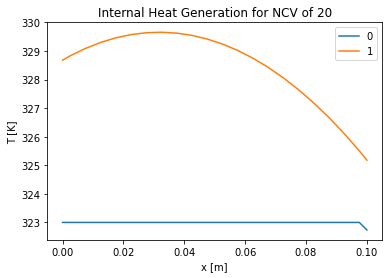

In [415]:
##POST PROCESSING

%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("Internal Heat Generation for NCV of 20")    
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_solns_2 = T_solns.copy()
grid2_xP=grid.xP

In [416]:
##Problem 3 with a number of control volumes of 40

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ho = 280

#Ambient temperatures
T1=323
T2=313

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 323

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = RobinBc(T, grid, ho, k, T1, BoundaryLocation.WEST) #self, phi, grid, h, k, Tamb, loc
east_bc = RobinBc(T, grid, ho, k, T2, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
qo=50000
Internal = InternalConvection(grid, qo)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = Internal.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    print(T_solns[-1])

Iteration = 0; Max. Resid. = 0.06191479400750149; Avg. Resid. = 0.009033239700375076
[328.67857143 328.83145604 329.08914835 329.29876374 329.4603022
 329.57376374 329.63914835 329.65645604 329.62568681 329.54684066
 329.41991758 329.24491758 329.02184066 328.75068681 328.43145604
 328.06414835 327.64876374 327.1853022  326.67376374 326.11414835
 325.50645604 325.17857143]
Iteration = 1; Max. Resid. = 1.2494345835722953e-14; Avg. Resid. = 6.445321706904927e-15


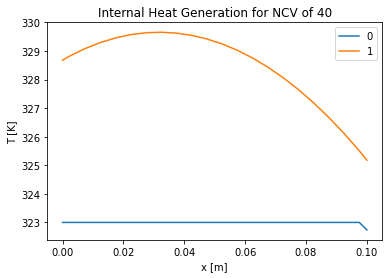

In [417]:
##POST PROCESSING

%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("Internal Heat Generation for NCV of 40")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_solns_3 = T_solns.copy()
grid3_xP=grid.xP

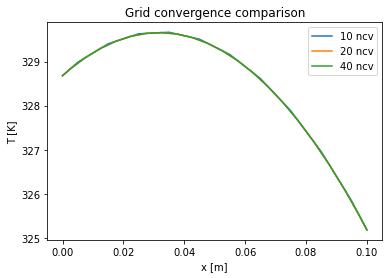

In [418]:
##Grid convergence comparison with the dirverse plots

%matplotlib inline
import matplotlib.pyplot as plt

fig5, ax = plt.subplots()


plt.title("Grid convergence comparison")
ax.plot(grid1_xP, T_solns_1[-1], label="10 ncv")
ax.plot(grid2_xP, T_solns_2[-1], label="20 ncv")
ax.plot(grid3_xP, T_solns_3[-1], label="40 ncv")


ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.legend()
plt.show()

### Grid convergence analysis

From the previous plot is possible to notice that the numerical solution using a number of control volumes of 10 provides a correct aproximation of the expected result comparable with the other number of control values used. Despite this, the optimal number of control volumes in this case is 20 because the ncv of 10 does not provide enough data to generate an smooth curve with the results and it leaves room for more approximation than actual calculation of the temperature in the domain.

Is important to notice the behaviour of the residual in all the cases with the diverse number of control volumes. They all converge in one iteration since the linearity of the system allows the convergence as fast as one iteration. The residual stays in the same order of magnitude in the number of control volumes of 20 and 40 (power of -14) while for the number of control volumes of 10 it increase by one (power of -15) which it expected.

### Numerical Solution used for analysis:

As previously mentioned, the numerical solution used for analysis is the one that uses the grid with 20 number of control volumes, for this solution the results obtained for the max temperature in the domain and its locations is as follow:

In [419]:
print ("The highest temperature is :", max_value)
print ("The location of the highest temperature is in", grid.xP[7], "From the origin") #This value was found manually from T_solns

The highest temperature is : 329.6564560439555
The location of the highest temperature is in 0.0325 From the origin


## Analytical Solution

In order to compare the accuracy of the results for this problem, the following code solves the temperatures of the wall using the formulas of the text book of Heat Transfer Incropera, assuming it as a plane wall with a heat source inside. 

After doing a energy balance in the wall, we obtain the temperature distribution as a function of X. For this problem it is considerate the origin of the x-axis in the middle of the thickness of the wall and to be able to use the different ambient temperatures, -L is going to be considerate the west side of the wall and +L is going to be the east side of the wall. 



[328.67857143 328.97379836 329.21575447 329.40443974 329.53985419
 329.62199781 329.6508706  329.62647256 329.54880369 329.41786399
 329.23365347 328.99617211 328.70541993 328.36139691 327.96410307
 327.5135384  327.0097029  326.45259657 325.84221941 325.17857143]
The max temperature is:  329.6508705975465


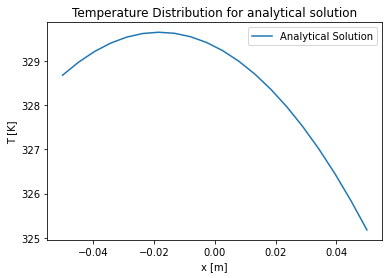

In [420]:
import numpy as np
import math

L = lx/2
x = np.linspace(-(lx/2),(lx/2),ncv2)
T_an = ((qo/(2*k))*(L**2 - x**2)) + ((T2-T1)*x*(7/2)) + ((T1+T2)/2) + ((qo*L)/ho)
print(T_an)

max_an = np.max(T_an)
print ("The max temperature is: ",max_an)

%matplotlib inline
import matplotlib.pyplot as plt

fig6, ax = plt.subplots()

plt.title("Temperature Distribution for analytical solution")
ax.plot(x, T_an, label="Analytical Solution")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.legend()
plt.show()



The location of the max analytical temperature is in 0.03684210526315789


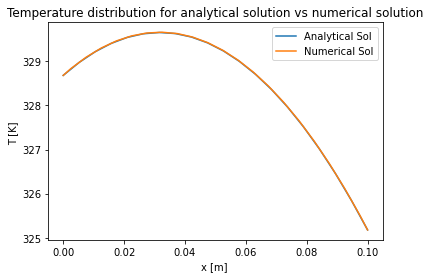

In [421]:
##Comparison between Analytical Solution and Numerical Solution

fig7, ax = plt.subplots()

x_an = np.linspace (0, lx, (ncv)) #Defining a new x distribution for the analytical solution 
print("The location of the max analytical temperature is in", x_an[7])

ax.plot(x_an, T_an, label="Analytical Sol")
ax.plot(grid2_xP, T_solns_2[-1], label="Numerical Sol")


plt.title("Temperature distribution for analytical solution vs numerical solution")
ax.set_xlabel("x [m] ")
ax.set_ylabel("T [K] ")
ax.legend()
plt.show()

### Analysis of the results

For this problem, where the source is a constant heat inside of the wall, the effects of conduction and convection will impact the distribution of the temperatures on the wall. From the background theory, in the middle of the wall, the temperature gradient is zero and for this reason the analytical solution was perform with the origin of the axis in the middle of the wall. The results obtained from the temperature distribution through the wall, were plotted with the same x-axis reference for both analytical and numerical solution in order to be able to compare them.

From the numerical solution a maximum temperature of 329.6565 [K] was obtained in a location of 0.0325 [m] from the west wall (To=323 K). While from the analytical solution a maximum temperature of 329.6598 [K] was obtained in a location of 0.0368 [m] from the west wall as well. Comparing this two results, is possible to conclude that the numerical solution provides an accurate result compared with the analytical solution, with a difference of less than 1%.

From the previous plot, is also possible to notice how do the curves match their results along the entire x-axis. 

The result obtained shows how the location of the maximum temperature is closer to the side of the wall that has an outside temperature higher. Since the ambient temperature of each side of the wall are not the same, there will not be simetry with the distribution of the temperature inside of the wall despite the fact that the source is constan. This demonstrate the effects of the convection and how the source will add heat to the ambient. 

For the numerical solution purposes, the addition of the convection as a source term in one-dimensional analysis provides an accurate aproximation to the reality of the problem.

## Problem 4 - Radiation 

Solve the following problem using the square bar geometry given in question 1 with $T_\infty$ = 0 [K]. Assume that the convection coefficient is $h$ = 0 [W/m$^2\cdot$K], the emmisivity is $\epsilon$ = 1.0, the end temperatures are $T_1$ = 400 [K] and $T_2$ = 0 [K]. Try solving this problem using the following linearizations of the radiation source term:

- Apply $q_o^{\prime\prime} = \epsilon \sigma (T^4 - T_\infty^4)$ into the residual and do not include any contribution from this term into the Jacobian matrix. This is an explicit implementation of the source term.
- Apply $q_o^{\prime\prime} = \epsilon \sigma (T^4 - T_\infty^4)$ into the residual and include the linearizaton $\partial q_o^{\prime\prime}/\partial T$ into the Jacobian matrix. This is an implicit implementation of the source term.

Solve using each linearization assuming the material is:

- Steel, for which: $k$ = 60 [W/m$\cdot$K], $c_p$ = 430 [J/kg$\cdot$K]
- Wood, for which: $k$ = 0.1 [W/m$\cdot$K], $c_p$ = 1.3 [J/kg$\cdot$K]

Explain any differences that you observe.

### Solution problem 4

In this case, for the discretization of the source term, radiation is used. The following class definitions are developed using explicit and implicit method on the source term. Followed by the numerical solution methods used with each of them using steel and wood to compare their results.

In [422]:

class SurfaceRadiationModelExplicit:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Ep, Sig, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Ep = Ep
        self._Sig = Sig
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = grid.Ao*self._Ep*self._Sig*(((self._T[1:-1])**4) - ((self._To)**4))
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [423]:
class SurfaceRadiationModelImplicit:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Ep, Sig, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Ep = Ep
        self._Sig = Sig
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = (grid.Ao*self._Ep*self._Sig*(((self._T[1:-1])**4) - ((self._To)**4)))
        
        # Calculate the linearization coefficients
        coeffP = (self._Ep*self._Sig*3*grid.Ao)*((self._T[1:-1])**3)
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

### NUMERICAL SOLUTION USING EXPLICIT METHOD FOR STEEL

The following solution is done using 3 different grids that will change based on the number of control volumes.

In [424]:
## EXPLICIT METHOD FOR STEEL FOR A NUMBER OF CONTROL VALUES OF 10

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 200
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=(5.67)*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationEx = SurfaceRadiationModelExplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationEx.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T)) 
    
Tsolns1 = T_solns[-1]
grid1 = grid.xP

Iteration = 0; Max. Resid. = 90.91853999999992; Avg. Resid. = 12.734831999999992
Iteration = 1; Max. Resid. = 1.0873782864446024; Avg. Resid. = 0.7839777109649512
Iteration = 2; Max. Resid. = 0.32011189465678547; Avg. Resid. = 0.12464167650821992
Iteration = 3; Max. Resid. = 0.11967254563025254; Avg. Resid. = 0.04413968265073628
Iteration = 4; Max. Resid. = 0.04069185923913121; Avg. Resid. = 0.014448965093686516
Iteration = 5; Max. Resid. = 0.013384695293585214; Avg. Resid. = 0.004725581121881792
Iteration = 6; Max. Resid. = 0.004361387134610206; Avg. Resid. = 0.0015362844712842236
Iteration = 7; Max. Resid. = 0.0014188094532869844; Avg. Resid. = 0.0004996436927359017
Iteration = 8; Max. Resid. = 0.00046127687383212823; Avg. Resid. = 0.00016241632908497848
Iteration = 9; Max. Resid. = 0.000149956587170319; Avg. Resid. = 5.279960219574781e-05
Iteration = 10; Max. Resid. = 4.874742934823928e-05; Avg. Resid. = 1.7163731671004e-05
Iteration = 11; Max. Resid. = 1.584662320053276e-05; Avg. R

In [425]:
## EXPLICIT METHOD FOR STEEL FOR A NUMBER OF CONTROL VALUES OF 20

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 200
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=(5.67)*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationEx = SurfaceRadiationModelExplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationEx.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T)) 
    
Tsolns2 = T_solns[-1]
grid2 = grid.xP    

Iteration = 0; Max. Resid. = 180.45926999999986; Avg. Resid. = 12.413342999999994
Iteration = 1; Max. Resid. = 0.7524631561383215; Avg. Resid. = 0.4023897383247584
Iteration = 2; Max. Resid. = 0.16446998995065693; Avg. Resid. = 0.0629275095988042
Iteration = 3; Max. Resid. = 0.060417388109803405; Avg. Resid. = 0.021881564577871375
Iteration = 4; Max. Resid. = 0.02002768709995406; Avg. Resid. = 0.0070733353038130884
Iteration = 5; Max. Resid. = 0.006508517149250659; Avg. Resid. = 0.0022904775536608754
Iteration = 6; Max. Resid. = 0.0020994702421383016; Avg. Resid. = 0.0007378641634369115
Iteration = 7; Max. Resid. = 0.0006768322869367127; Avg. Resid. = 0.00023784373513128097
Iteration = 8; Max. Resid. = 0.00021809359799140893; Avg. Resid. = 7.663332845189155e-05
Iteration = 9; Max. Resid. = 7.027598441933236e-05; Avg. Resid. = 2.4693414912055443e-05
Iteration = 10; Max. Resid. = 2.2644126136062148e-05; Avg. Resid. = 7.956594740986216e-06
Iteration = 11; Max. Resid. = 7.296353197960848e-

In [426]:
## EXPLICIT METHOD FOR STEEL FOR A NUMBER OF CONTROL VALUES OF 40

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 200
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=(5.67)*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationEx = SurfaceRadiationModelExplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationEx.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T)) 
    
Tsolns3 = T_solns[-1]
grid3 = grid.xP


Iteration = 0; Max. Resid. = 360.2296349999997; Avg. Resid. = 12.218153249999991
Iteration = 1; Max. Resid. = 0.4341500029509201; Avg. Resid. = 0.2013428579859366
Iteration = 2; Max. Resid. = 0.0827407465282119; Avg. Resid. = 0.0315683007178744
Iteration = 3; Max. Resid. = 0.030214437688421525; Avg. Resid. = 0.010917423171172027
Iteration = 4; Max. Resid. = 0.010059767321997426; Avg. Resid. = 0.00351966180760086
Iteration = 5; Max. Resid. = 0.0032649528151186824; Avg. Resid. = 0.0011374092569652293
Iteration = 6; Max. Resid. = 0.001051593461180722; Avg. Resid. = 0.0003657137102585396
Iteration = 7; Max. Resid. = 0.0003383869655220195; Avg. Resid. = 0.00011766508261245632
Iteration = 8; Max. Resid. = 0.0001088383480130628; Avg. Resid. = 3.7841558145108045e-05
Iteration = 9; Max. Resid. = 3.500590757488098e-05; Avg. Resid. = 1.2171072774356886e-05
Iteration = 10; Max. Resid. = 1.125868160706256e-05; Avg. Resid. = 3.9144582482537504e-06
Iteration = 11; Max. Resid. = 3.6210491277111068e-06

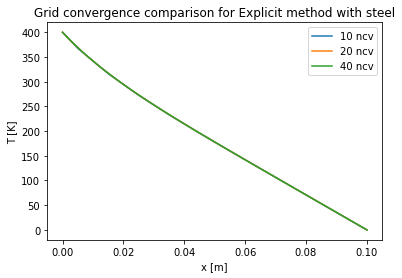

In [427]:
%matplotlib inline
import matplotlib.pyplot as plt

fig5, ax = plt.subplots()


plt.title("Grid convergence comparison for Explicit method with steel")
ax.plot(grid1, Tsolns1, label="10 ncv")
ax.plot(grid2, Tsolns2, label="20 ncv")
ax.plot(grid3, Tsolns3, label="40 ncv")


ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.legend()
plt.show()

### IMPLICIT METHOD FOR STEEL

The following solution uses 3 different number of control volumes to find the most optimal for the numerical solution

In [428]:
## IMPLICIT METHOD FOR STEEL USING NCV OF 10

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 300
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=5.67*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationIm = SurfaceRadiationModelImplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationIm.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
T_plot1 = T_solns [-1]
grid1 = grid.xP

Iteration = 0; Max. Resid. = 90.91853999999992; Avg. Resid. = 12.734831999999992
Iteration = 1; Max. Resid. = 1.5698162787441172; Avg. Resid. = 0.509252724639849
Iteration = 2; Max. Resid. = 0.02433736024910238; Avg. Resid. = 0.010015685175072613
Iteration = 3; Max. Resid. = 0.0017713813522539645; Avg. Resid. = 0.000638490659569331
Iteration = 4; Max. Resid. = 0.00011797785643219427; Avg. Resid. = 4.1725599937163104e-05
Iteration = 5; Max. Resid. = 7.739124036065803e-06; Avg. Resid. = 2.7275718269693674e-06
Iteration = 6; Max. Resid. = 5.061301067144086e-07; Avg. Resid. = 1.782476931590103e-07


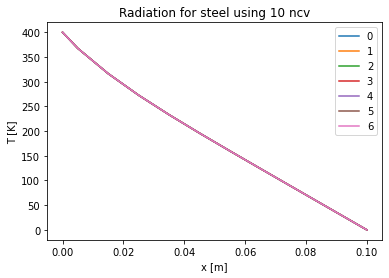

In [429]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T_plot, label=str(i))
    i += 1

plt.title("Radiation for steel using 10 ncv")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_solns_1 = T_solns[-1]
grid1_xP=grid.xP

In [430]:
## IMPLICIT METHOD FOR STEEL USING NCV OF 20

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 300
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=5.67*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationIm = SurfaceRadiationModelImplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationIm.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
T_plot2 = T_solns[-1]
grid2 = grid.xP

Iteration = 0; Max. Resid. = 180.45926999999986; Avg. Resid. = 12.413342999999994
Iteration = 1; Max. Resid. = 0.8513788843393719; Avg. Resid. = 0.25879724097773354
Iteration = 2; Max. Resid. = 0.012043218675018452; Avg. Resid. = 0.004874858502688662
Iteration = 3; Max. Resid. = 0.000865749406614047; Avg. Resid. = 0.00030937821193496406
Iteration = 4; Max. Resid. = 5.706959838075454e-05; Avg. Resid. = 2.0113336847442706e-05
Iteration = 5; Max. Resid. = 3.714274421029451e-06; Avg. Resid. = 1.3059827531817587e-06
Iteration = 6; Max. Resid. = 2.411468441598785e-07; Avg. Resid. = 8.474721653115742e-08


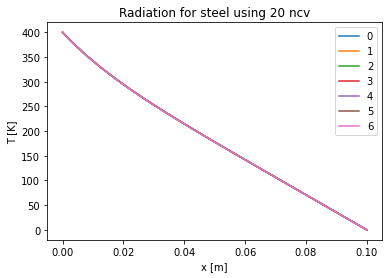

In [431]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T_plot2, label=str(i))
    i += 1

plt.title("Radiation for steel using 20 ncv")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()



In [432]:
## IMPLICIT METHOD FOR STEEL USING NCV OF 40

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 300
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=5.67*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationIm = SurfaceRadiationModelImplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationIm.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
T_plot3 = T_solns[-1]
grid3 = grid.xP

Iteration = 0; Max. Resid. = 360.2296349999997; Avg. Resid. = 12.218153249999991
Iteration = 1; Max. Resid. = 0.44245846770233876; Avg. Resid. = 0.1299084064669775
Iteration = 2; Max. Resid. = 0.006038003837170236; Avg. Resid. = 0.0024116597063519015
Iteration = 3; Max. Resid. = 0.00043368264800874856; Avg. Resid. = 0.00015355576222344939
Iteration = 4; Max. Resid. = 2.858136245070808e-05; Avg. Resid. = 9.97310791624717e-06
Iteration = 5; Max. Resid. = 1.8582487769092104e-06; Avg. Resid. = 6.466347264547257e-07
Iteration = 6; Max. Resid. = 1.2048224012906061e-07; Avg. Resid. = 4.189874468845674e-08


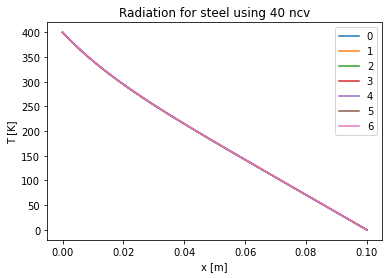

In [433]:
%matplotlib inline
import matplotlib.pyplot as plt

#plt.figure(figsize=(7,7))

i = 0
for T in T_solns:
    plt.plot(grid.xP, T_plot3, label=str(i))
    i += 1


plt.title("Radiation for steel using 40 ncv")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_plot_steel = T_plot3

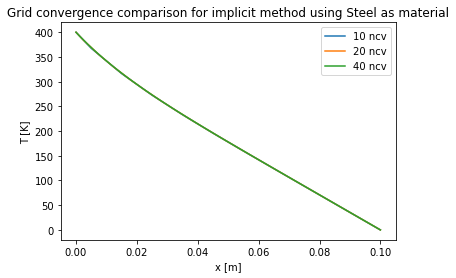

In [434]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2, ax = plt.subplots()

ax.plot(grid1, T_plot1, label="10 ncv")
ax.plot(grid2, T_plot2, label="20 ncv")
ax.plot(grid3, T_plot3, label="40 ncv")

plt.title("Grid convergence comparison for implicit method using Steel as material")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.legend()
plt.show()

### Grid convergence Analysis for the Implicid Method

For this case, the diverse number of control volumes used in this analysis provided similar approximation in the solution of the temperature distribution along the bar. The residuals also provided the same order of magnitude in all the cases. For since the result is very similar between all the control volumes, for this case 10 number of control volumes could be optimar to use.

### Comparison between Explicit Method and Implicit Method for STEEL as a material

For this case both method converged to a solution. The convergence of both methods took more than one iteration compared with the problems that were analyzed before. 

As mentioned previously, the discretization of each term of the Navier-Stokes equations allows us to linearize them in order to solver the system of equations. This linearization uses Newtons method and when the equations are linear the solution converges in one iteration. 

For the case of this problem where the source is defined by radiation, the temperatures are to the power of 4 which its linearization will still provide a non-linear terms that will make the solution to take more than one iteration to converge. 

For the explicit method, since the source term is not being linearized to the ap coefficient and just being added as source, the power of 4, makes this method to take the double of iterations to converge compared with the implicit method. Since for the implicit method the linearization is applied to the ap coefficient of the jacobian, this method takes less iterations to converge. 

The difference between the numbers of iterations between each method is expected. Despite the fact that the numbers of iterations is the double for explicit than for implicit, the order of magnitude of the residuals stays the same, which provides information about the accuracy of each method that is as expected. 

In this problem is noticeable that the conduction through the bar allows the temperature drop drastically from one extreme to the other and that the effect of radiation has a small effect on this temperature distribution to prevent that it drops this drastical.

### USING WOOD AS MATERIAL

In [435]:
## EXPLICIT METHOD FOR STEEL FOR A NUMBER OF CONTROL VALUES OF 10

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 50
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 200
converged = 1e-6

# Define thermophysical properties
k = 0.1

# Define radiation parameters
Ep=1
Sig=(5.67)*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationEx = SurfaceRadiationModelExplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationEx.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T)) 

Iteration = 0; Max. Resid. = 0.9337079999999993; Avg. Resid. = 0.19635967999999995
Iteration = 1; Max. Resid. = 99194100.19674183; Avg. Resid. = 40279114.47972903
Iteration = 2; Max. Resid. = 1.207778980906578e+42; Avg. Resid. = 4.0930563137983286e+41
Iteration = 3; Max. Resid. = 1.5394036145284168e+178; Avg. Resid. = 4.99031988415923e+177
Iteration = 4; Max. Resid. = inf; Avg. Resid. = inf
Iteration = 5; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 6; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 7; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 8; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 9; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 10; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 11; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 12; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 13; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 14; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 15; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 16; Max. Resid. 

<ipython-input-422-064339902e27>:16: RuntimeWarning: overflow encountered in power
  source = grid.Ao*self._Ep*self._Sig*(((self._T[1:-1])**4) - ((self._To)**4))


Iteration = 192; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 193; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 194; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 195; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 196; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 197; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 198; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 199; Max. Resid. = nan; Avg. Resid. = nan


### Analysis on this result

In this case, the explicit method to solve the source term in the equations does not converge. 
It is possible to notice that the k value on the case of the wood is an order of magnitude smalled than the conductivity of the steel.
In this case, even after the linearization of the discrete factors, is not possible to obtain a linear equation for the coefficients of ap, which leads to a divergence of the numerical solution because the approximization to the values will never get close to a solution that achieve the expected residual. 
As it was possible to notice before, the implicit method by itself can converge, but in this case, the value of the conductivity affects directly the diffusion term and combined with the non-linearlity of the source, the method cannot converge in this case.

### IMPLICIT METHOD USING WOOD AS MATERIAL

In [436]:
## IMPLICIT METHOD FOR WOOD USING NCV OF 10

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 300
converged = 1e-6

# Define thermophysical properties
k = 0.1

# Define radiation parameters
Ep=1
Sig=5.67*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationIm = SurfaceRadiationModelImplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationIm.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
T_plot1 = T_solns [-1]
grid1 = grid.xP

Iteration = 0; Max. Resid. = 1.0685399999999998; Avg. Resid. = 0.9285399999999999
Iteration = 1; Max. Resid. = 0.24007284198784046; Avg. Resid. = 0.18199274079088157
Iteration = 2; Max. Resid. = 0.06160456400574215; Avg. Resid. = 0.034913956152523254
Iteration = 3; Max. Resid. = 0.012246112693599409; Avg. Resid. = 0.006780551206593417
Iteration = 4; Max. Resid. = 0.0027887734016832995; Avg. Resid. = 0.0011532888785882277
Iteration = 5; Max. Resid. = 0.0003882801051636771; Avg. Resid. = 0.00014367372482693798
Iteration = 6; Max. Resid. = 2.145710384507854e-05; Avg. Resid. = 7.855632594332427e-06
Iteration = 7; Max. Resid. = 4.698564797968839e-06; Avg. Resid. = 2.085339002682897e-06
Iteration = 8; Max. Resid. = 1.6298643683403113e-06; Avg. Resid. = 5.805381946203386e-07
Iteration = 9; Max. Resid. = 6.160673908933711e-07; Avg. Resid. = 1.6350440640557547e-07


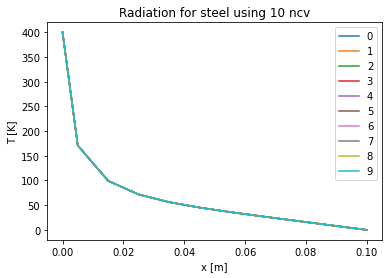

In [437]:
%matplotlib inline
import matplotlib.pyplot as plt

#plt.figure(figsize=(7,7))

i = 0
for T in T_solns:
    plt.plot(grid.xP, T_plot1, label=str(i))
    i += 1


plt.title("Radiation for steel using 10 ncv")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

In [438]:
## IMPLICIT METHOD FOR WOOD USING NCV OF 30

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 300
converged = 1e-6

# Define thermophysical properties
k = 0.1

# Define radiation parameters
Ep=1
Sig=5.67*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationIm = SurfaceRadiationModelImplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationIm.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
T_plot2 = T_solns [-1]
grid2 = grid.xP

Iteration = 0; Max. Resid. = 0.7561800000000007; Avg. Resid. = 0.31617999999999996
Iteration = 1; Max. Resid. = 0.19258432114793125; Avg. Resid. = 0.06326163605182251
Iteration = 2; Max. Resid. = 0.0273521131170002; Avg. Resid. = 0.011990191797133893
Iteration = 3; Max. Resid. = 0.005053612639809987; Avg. Resid. = 0.002207936914772187
Iteration = 4; Max. Resid. = 0.0009894033150710157; Avg. Resid. = 0.0003907080830281875
Iteration = 5; Max. Resid. = 0.0001419432456689161; Avg. Resid. = 5.031211473082401e-05
Iteration = 6; Max. Resid. = 7.78931108309604e-06; Avg. Resid. = 2.5971214997085742e-06
Iteration = 7; Max. Resid. = 1.6383156067857011e-06; Avg. Resid. = 6.653827604312599e-07
Iteration = 8; Max. Resid. = 6.153577518722142e-07; Avg. Resid. = 1.879827746289048e-07


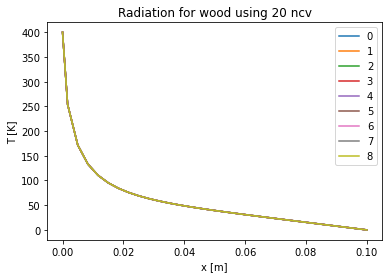

In [439]:
%matplotlib inline
import matplotlib.pyplot as plt

#plt.figure(figsize=(7,7))

i = 0
for T in T_solns:
    plt.plot(grid.xP, T_plot2, label=str(i))
    i += 1


plt.title("Radiation for wood using 20 ncv")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

In [440]:

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 300
converged = 1e-6

# Define thermophysical properties
k = 0.1

# Define radiation parameters
Ep=1
Sig=5.67*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationIm = SurfaceRadiationModelImplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationIm.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
T_plot3 = T_solns[-1]
grid3 = grid.xP

Iteration = 0; Max. Resid. = 0.8296349999999995; Avg. Resid. = 0.23963499999999996
Iteration = 1; Max. Resid. = 0.18794425856199257; Avg. Resid. = 0.048169363333327095
Iteration = 2; Max. Resid. = 0.02201458483681281; Avg. Resid. = 0.00895477261288264
Iteration = 3; Max. Resid. = 0.0038592968917765557; Avg. Resid. = 0.0016557479956238
Iteration = 4; Max. Resid. = 0.000743307773016307; Avg. Resid. = 0.00029347789175222875
Iteration = 5; Max. Resid. = 0.00010714384019116042; Avg. Resid. = 3.7731070838520225e-05
Iteration = 6; Max. Resid. = 5.860085513528145e-06; Avg. Resid. = 1.9388506690935635e-06
Iteration = 7; Max. Resid. = 1.2395308573427775e-06; Avg. Resid. = 5.094888224487338e-07
Iteration = 8; Max. Resid. = 4.853450025557593e-07; Avg. Resid. = 1.4383677017831661e-07


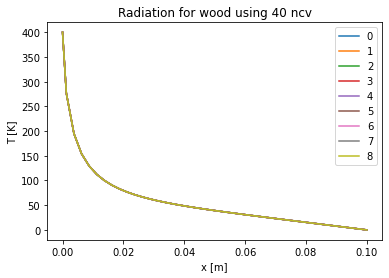

In [441]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T_plot3, label=str(i))
    i += 1

plt.title("Radiation for wood using 40 ncv")
plt.xlabel("x [m]")
plt.ylabel("T [K]")
plt.legend()
plt.show()

T_plot_wood = T_solns[-1]
grid3 = grid.xP


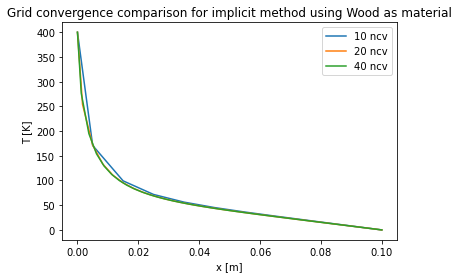

In [442]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2, ax = plt.subplots()

ax.plot(grid1, T_plot1, label="10 ncv")
ax.plot(grid2, T_plot2, label="20 ncv")
ax.plot(grid3, T_plot3, label="40 ncv")

plt.title("Grid convergence comparison for implicit method using Wood as material")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.legend()
plt.show()

### Grid Convergence Analysis for WOOD

Comparing the results of the grid convergence analysis of the steel, the results of this problem using wood does need a finer number of control volume in order to be grid independent. In this case comparing the coarse grid (10 number of control volumes) with the finest (40 ncv) is possible to notice how the curve of the finest mesh provides a smoother results which is more accurate in this case. The most optimal mesh starts from the grid of 20 ncv. For the comparison between the wood and the steel in this method it will be used the finer mesh on the following plot.

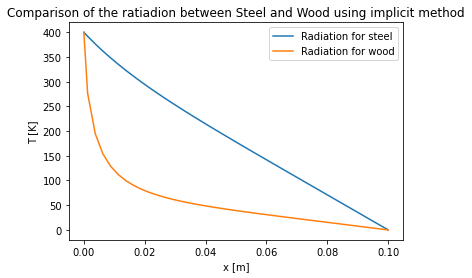

In [443]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2, ax = plt.subplots()

ax.plot(grid3, T_plot_steel, label="Radiation for steel")
ax.plot(grid3, T_plot_wood, label="Radiation for wood")

plt.title("Comparison of the ratiadion between Steel and Wood using implicit method")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.legend()
plt.show()

### Analysis of the results obtained between the use of WOOD and the use of STEEL

Basedon the previous plot, is possible to notice that since the steel has a higher conductivity, it resist more to the radiation effect on the distribution of the temperature, which makes the heat transfer more through conductivity making the temperature drop drastically from one extreme of the bar to the other. 

On the opposite case, the wook, that has a small value of the conductivity, since the heat transfer slowly through conduction, the effects of radiations have more impart on the heat transfer allowing the temperature to be reduce more gradually along the x-axis. 

The results obtained for steel and wood are as expected. As it was shown in the results of the implicit method using wood, the effect of the conductivity will also have an impact on the convergence of this method but since the non linear terms in this case are constantly being updated, for the implicit method it will still converge. 

The number of iterations that the method converged using wood as a material is 20% higher than the number of iterations obtained from the method using steel. This has to do with the effects of the diffusion model based on the conductivity of the materials which is expected to affect the convergence and number of iterations. 